<a href="https://colab.research.google.com/github/Olivia-Feldman/NUGAN-DISTGAN/blob/Andrew/NuGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up the environment

In [1]:
import torch
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
from math import floor

# Download the MNIST dataset

[MNIST PyTorch Docs](https://pytorch.org/vision/stable/datasets.html#mnist)

In [2]:
# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

# Showing shape of train and test dataset

In [3]:
print("Train Shape:", train_dataset.data.shape, "Test Shape:", test_dataset.data.shape)

Train Shape: torch.Size([60000, 28, 28]) Test Shape: torch.Size([10000, 28, 28])


In [4]:
class Net(nn.Module):
    def __init__(self, input_dim=1, output_dim=10, input_size=28, base_size=64):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.base_size = base_size
        # self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # self.conv2 = nn.Conv2d(16, 128, kernel_size=3, stride=1, padding=1)
        # self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        # self.fc1 = nn.Linear(128 * 8 * 8, 512)
        # self.fc2 = nn.Linear(512, 128)
        # self.fc3 = nn.Linear(128, 10)

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.base_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.base_size, 2*self.base_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(2*self.base_size),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.ReLU(),
        )

        #initialize_weights(self)

    def forward(self, x):
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = F.relu(self.conv3(x))
        # x = x.view(-1, 128 * 8 * 8)
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        x = self.conv(x)
        x = x.view(-1, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)
        return x

In [5]:
class Classifier():
    def __init__(self, epoch=20, batch_size=500):

        self.epoch_range = epoch
        self.batch_size = batch_size
        valid_ratio = 0.3

        nb_train = int((1.0 - valid_ratio) * len(train_dataset))
        nb_valid =  int(valid_ratio * len(train_dataset))
        train_split_dataset, valid_split_dataset = torch.utils.data.dataset.random_split(train_dataset, [nb_train, nb_valid])

        self.trainloader = torch.utils.data.DataLoader(train_split_dataset, batch_size=self.batch_size,
                                          shuffle=True)
        self.validloader = torch.utils.data.DataLoader(valid_split_dataset, batch_size=self.batch_size,
                                          shuffle=True)
        self.testloader = torch.utils.data.DataLoader(test_dataset, 
                                        batch_size=self.batch_size, 
                                        shuffle=False,
                                        num_workers=1)

        self.net = Net().cuda()

        self.criterion = nn.CrossEntropyLoss().cuda()

        self.optimizer = optim.Adam(self.net.parameters(), lr=0.00146)

        from google.colab import drive
        drive.mount('/content/drive')
        self.PATH = 'cifar10_net_test_3.pth'


        # Function to train the CNN classifier
#--------------------------------------------------------------------------------------------------------

    def train(self):

        self.training_loss = []
        self.validation_loss = []

        start_time = time.time()
        best_loss = np.float('inf')
        for epoch in range(self.epoch_range): 

            running_loss = 0.0
            for i, data in enumerate(self.trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                # inputs, labels = data[0].to(device), data[1].to(device)
                inputs, labels = data[0].cuda(), data[1].cuda()

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.net(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                # print statistics
                running_loss += loss.item()

            epoch_loss = running_loss / (i+1)
            self.training_loss.append(epoch_loss)
            print("Epoch: ", epoch, " train loss: ", '%.3f' % epoch_loss)

            #---------------------------------

            with torch.no_grad(): 
                running_loss = 0.0

                for i, data in enumerate(self.validloader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    #inputs, labels = data[0].to(device), data[1].to(device)
                    inputs, labels = data[0].cuda(), data[1].cuda()

                    # forward 
                    outputs = self.net(inputs)
                    loss = self.criterion(outputs, labels)

                    # print statistics
                    running_loss += loss.item()


                epoch_loss = running_loss / (i+1)
                self.validation_loss.append(epoch_loss)
                print("Epoch: ", epoch, " validation loss: ", '%.3f' % epoch_loss)

                # save the best model based on validation loss
                if epoch_loss < best_loss:
                    torch.save(self.net.state_dict(), self.PATH)
                    best_loss = epoch_loss

        time_elap = (time.time() - start_time) // 60
        print('Finished Training in %d mins' % time_elap)

        plt.plot(range(self.epoch_range), self.training_loss, 'k-')
        plt.title('train loss vs. epoch')
        plt.xlabel('epoch')
        plt.ylabel('train_loss')
        plt.show()

        plt.plot(range(self.epoch_range), self.validation_loss, 'k-')
        plt.title('validation loss vs. epoch')
        plt.xlabel('epoch')
        plt.ylabel('validation_loss')
        plt.show()


    def test_accuracy(self):

        correct = 0
        total = 0

        with torch.no_grad():
            for data in self.testloader:
                images, labels = data
                outputs = self.net(images.cuda())
                #print("Outputs shape:", outputs.shape)
                _, predicted = torch.max(outputs.data, 1)
                #print("predicted:", predicted.shape)
                total += labels.size(0)
                correct += (predicted == labels.cuda()).sum().item()

        print('Accuracy of the network on the 10000 test images: %.3F %%' % (
            100 * correct / total))


# Train MNIST Classifier

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch:  0  train loss:  0.228
Epoch:  0  validation loss:  0.083
Epoch:  1  train loss:  0.064
Epoch:  1  validation loss:  0.063
Epoch:  2  train loss:  0.041
Epoch:  2  validation loss:  0.054
Epoch:  3  train loss:  0.028
Epoch:  3  validation loss:  0.050
Epoch:  4  train loss:  0.020
Epoch:  4  validation loss:  0.053
Epoch:  5  train loss:  0.016
Epoch:  5  validation loss:  0.050
Epoch:  6  train loss:  0.009
Epoch:  6  validation loss:  0.047
Epoch:  7  train loss:  0.007
Epoch:  7  validation loss:  0.051
Epoch:  8  train loss:  0.007
Epoch:  8  validation loss:  0.048
Epoch:  9  train loss:  0.005
Epoch:  9  validation loss:  0.048
Epoch:  10  train loss:  0.004
Epoch:  10  validation loss:  0.051
Epoch:  11  train loss:  0.005
Epoch:  11  validation loss:  0.056
Epoch:  12  train loss:  0.005
Epoch:  12  validation loss:  0.055
Epoch:  13  train lo

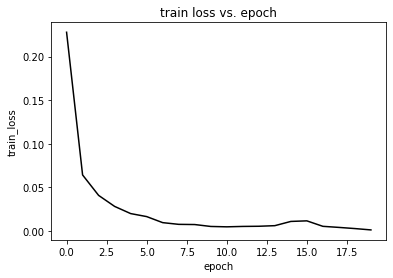

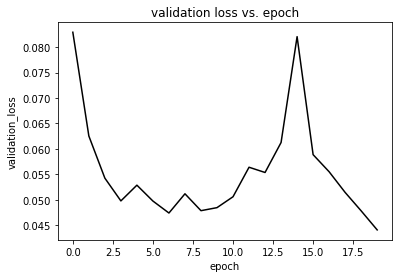

In [6]:
classifier = Classifier()
classifier.train()

In [7]:
classifier.test_accuracy()

Accuracy of the network on the 10000 test images: 98.860 %


# Define a function to initialize the weights of the network


In [8]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [9]:
def visualize_results(gan):
      mtx_size = 10
      sample_z_ = torch.rand((mtx_size * mtx_size, gan.z_dim)).cuda()
      samples = gan.G(sample_z_)
      samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
      samples = (samples + 1) / 2
      plt.figure(figsize=((mtx_size, mtx_size)))
      fig,ax = plt.subplots(mtx_size, mtx_size)

      i = 0
      for x in range(mtx_size):
          for y in range(mtx_size):
              i = x*mtx_size + y
              s=ax[x][y].imshow(np.squeeze(samples[i,]))
              s=ax[x][y].get_xaxis().set_visible(False)
              s=ax[x][y].get_yaxis().set_visible(False)
      s=plt.show()

# Method for determinign inception score of GAN

[Article for help implementing](https://machinelearningmastery.com/how-to-implement-the-inception-score-from-scratch-for-evaluating-generated-images/)

In [10]:
def inception_score(gan, n_split=10, eps=1E-16):

      num_images = 100
      sample_z_ = torch.rand((num_images, gan.z_dim)).cuda()
      #print(sample_z_.shape)
      samples = gan.G(sample_z_)
      #print(samples.shape)

      samples_np = samples.cpu().data.numpy()

      # enumerate splits of images/predictions
      scores = list()
      n_part = floor(num_images / n_split)

      for i in range(n_part):
          # retrieve subset of images
          ix_start, ix_end = i * n_part, (i+1) * n_part
          subset = samples_np[ix_start:ix_end]
          # convert from uint8 to float32
          subset = subset.astype('float32')
          # predict p(y|x)
          outputs = classifier.net(torch.from_numpy(subset).cuda())
          #print("outputs: ", outputs.shape)
          #print("\n\t", outputs)
          outputs = F.softmax(outputs, dim=1)
          #print("\tSoftmax: ", outputs)
          
          # y, p_yx = torch.max(outputs.data, 1)
          # print("p_yx: ", p_yx.shape)
          # print("\t", p_yx)
          #print(y.shape)
          p_yx_d = gan.D(torch.from_numpy(subset).cuda())
          #print("\tD: ", p_yx_d.shape)
          #print(p_yx.shape)
          #print(p_yx)
          p_yx = outputs.cpu().data.numpy()
          #print("p_yx numpy:\n\t", p_yx)
          #p_yx = np.expand_dims(p_yx, 0)
          #print(p_yx.shape)
          #print("p_yx expanded", p_yx)
          # calculate p(y)
          p_y = np.expand_dims(p_yx.mean(axis=0), 0)
          #print("p_y:\n\t", p_y)
          # calculate KL divergence using log probabilities
          kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
          #print("kl_d:\n\t", kl_d)
          # sum over classes
          sum_kl_d = kl_d.sum(axis=1)
          #print("sum_kl_d:\n\t", sum_kl_d)
          # average over images
          avg_kl_d = np.mean(sum_kl_d)
          #print("avg_kl_d:\n\t", avg_kl_d)
          # undo the log
          is_score = np.exp(avg_kl_d)
          #print("is_score:\n\t", is_score)
          #print('\n\n')
		      # store
          scores.append(is_score)
        
      # average across images
      is_avg, is_std = np.mean(scores), np.std(scores)
     
      return is_avg, is_std

      # Get predictions
      # The inception score has a lowest value of 1.0 and a highest value of the number of classes supported by the classification model; 
      # In the MNIST dataset, there are 10 classes
      #preds = np.zeros((N, 10))

In [11]:
from scipy.sparse import linalg

def get_eigenvectors(model, loss, dataloader):
    # Adds up the number of weights in the model
    num_params = sum(p.numel() for p in model.parameters())

    hv = HessianVector(model=model, 
                       dataloader=dataloader, 
                       loss=loss)
    
    A = linalg.LinearOperator((num_params,num_params), matvec=lambda v: hv.calculate(torch.tensor(v).float()))

    #print("\tGot eigenvectors", A.shape)
    # Gets 'k' with the Largest (algebraic) eigenvalues
    k = 10
    vals, vecs = linalg.eigsh(A, k=k, mode='LA')

    for val in vals:
        print("\t", val)

    #print("\tEigenvalues are {:.2f} and {:.2f}".format(vals[0],vals[1]))

# Calculates the Eigenvalues of the Discriminator


[linalg.eigsh](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigsh.html)

In [12]:
def get_d_eigenvectors(D, G, loss, dataloader):

    num_params = sum(p.numel() for p in D.parameters())

    hv = HessianVector(model=D, 
                       dataloader=dataloader, 
                       loss=loss)
    
    A = linalg.LinearOperator((num_params,num_params), matvec=lambda v: hv.calculate(torch.tensor(v).float()))

    print("\tGot eigenvectors", A.shape)
    # Gets 'k' with the Largest (algebraic) eigenvalues
    vals, vecs = linalg.eigsh(A, k=2, mode='LA')

    print("\tEigenvalues are {:.2f} and {:.2f}".format(vals[0],vals[1]))

# Hessian Vector Class



*   scipy.sparse.linalg.LinearOperator
  *   [Docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.LinearOperator.html)



In [13]:
class HessianVector():

    def __init__(self, model, dataloader, loss, percentage=0.2):
        self.size = int(sum(param.numel() for param in model.parameters()))
        self.grad_vec = torch.zeros(self.size)
        self.percentage = percentage
        self.dataloader = dataloader
        self.model = model
        self.loss = loss


    def calculate(self, vector):
        full_hessian = None
        # Place vector on the GPU
        vector = vector.cuda()

        grad_vec = None

        batch_grad = self.prepare_grad()

        #print("Batch Shape:", batch_grad.shape)

        self.zero_grad()
        # Take the second gradient
        grad_grad = torch.autograd.grad(batch_grad, self.model.parameters(), grad_outputs=vector, only_inputs=True, retain_graph=True)
        # Concatentate the results over the different components of the network
        hessian_vec_prod = torch.cat([g.contiguous().view(-1) for g in grad_grad])
        # Adds/Sets Full Hessian
        if full_hessian is not None:
            full_hessian += hessian_vec_prod
        else:
            full_hessian = hessian_vec_prod

        # Hessian must be returned on the CPU
        return full_hessian.cpu()

    def zero_grad(self):
        """
        Zeros out the gradient info for each parameters and vectorize
        """

        for p in self.model.parameters():
            if p.grad is not None:
                p.grad.data.zero_()


    def prepare_grad(self):


        grad_vec = None

        grad_dict = torch.autograd.grad(self.loss, self.model.parameters(), create_graph=True, retain_graph=True)
        grad_vec = torch.cat([g.contiguous().view(-1) for g in grad_dict])
        self.grad_vec = grad_vec
        return self.grad_vec


# Generator and Discriminator class definition

In [14]:
class Generator(nn.Module):
    def __init__(self, input_dim=100, output_dim=1, input_size=32, base_size=64):
        super(Generator, self).__init__()  
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = 28
        self.base_size = base_size    


        # self.fc1 = nn.Linear(self.input_dim, self.base_size)
        # self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        # self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        # self.fc4 = nn.Linear(self.fc3.out_features, self.output_dim * self.input_size * self.input_size)

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            #nn.ReLU(),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(2*self.base_size, self.base_size, 4, 2, 1),
            nn.BatchNorm2d(self.base_size),
            #nn.ReLU(),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(self.base_size, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )

        initialize_weights(self)
    
    # forward method
    def forward(self, x): 

        # x = F.leaky_relu(self.fc1(x), 0.2)
        # x = F.leaky_relu(self.fc2(x), 0.2)
        # x = F.leaky_relu(self.fc3(x), 0.2)
        # x = torch.tanh(self.fc4(x))
        # x = x.view(-1, self.output_dim, self.input_size, self.input_size)
        # return x

        x = self.fc(x)
        x = x.view(-1, 2*self.base_size, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)

        return x
    
class Discriminator(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, input_size=32, base_size=64):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.base_size = base_size

        # self.fc1 = nn.Linear(self.input_size * self.input_size, self.base_size)
        # self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        # self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        # self.fc4 = nn.Linear(self.fc3.out_features, self.output_dim)

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.base_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.base_size, 2*self.base_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(2*self.base_size),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(2*self.base_size * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )

        initialize_weights(self)
    
    # forward method
    def forward(self, x):

        # x = x.view(-1, self.input_size * self.input_size)
        # x = F.leaky_relu(self.fc1(x), 0.2)
        # x = F.dropout(x, 0.3)
        # x = F.leaky_relu(self.fc2(x), 0.2)
        # x = F.dropout(x, 0.3)
        # x = F.leaky_relu(self.fc3(x), 0.2)
        # x = F.dropout(x, 0.3)
        # return torch.sigmoid(self.fc4(x))

        x = self.conv(x)
        x = x.view(-1, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)

        return x

# Construction of GAN model

[Modifying gradients in PyTorch](https://discuss.pytorch.org/t/how-to-modify-the-gradient-manually/7483)

In [15]:
class GAN():
    def __init__(self,params):
        # parameters
        self.epoch = params['max_epochs']
        self.sample_num = 100
        self.batch_size = 300
        self.input_size = 28
        self.z_dim = params['z_dim']
        self.base_size = params['base_size']

        # load dataset
        self.data_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=self.batch_size, 
                                               shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=self.batch_size, 
                                               shuffle=True)
        data = self.data_loader.__iter__().__next__()[0]

        #mnist_dim = data.shape[1] * data.shape[2]

        #print(data.shape)
        #self.data_width = data.shape[2]
        #self.data_height = data.shape[3]

        # initialization of the generator and discriminator
        self.G = Generator(
            input_dim=self.z_dim,       # 16
            output_dim=data.shape[1],   # 1
            input_size=self.input_size, # 28
            base_size=self.base_size    # 64
            ).cuda()

        self.D = Discriminator(
            input_dim=data.shape[1],    
            output_dim=1,
            input_size=self.input_size, 
            base_size=self.base_size
            ).cuda()

        #print("Encoder", data.shape[1], self.input_size, self.base_size)
        #self.E = encoder(input_dim=data.shape[1], output_dim=self.z_dim, input_size=self.input_size, base_size=self.base_size).cuda()
        #self.G_optimizer = optim.SGD(self.G.parameters(), lr=params['lr_g'])
        #self.D_optimizer = optim.SGD(self.D.parameters(), lr=params['lr_d'])
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=params['lr_d'], betas=(params['beta1'], params['beta2']))
        #self.E_optimizer = optim.Adam(self.E.parameters(), lr=1e-2, weight_decay=1e-4)
        
        # initialization of the loss function

        self.BCE_loss = nn.BCELoss().cuda()
        #self.smooth_loss = nn.SmoothL1Loss().cuda()
        
        # Gettng a batch of noise to generate the fake data
        self.sample_z_ = torch.rand((self.batch_size, self.z_dim)).cuda()

        # Function to train the GAN, where you alternate between the training of the genenator and discriminator
#--------------------------------------------------------------------------------------------------------

    def train(self):

       # Setting empty arrays for storing the losses

        Ninner = 1
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []
        self.train_hist['IS_score'] = []

        # Setting up the labels for real and fake images
        #self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1).cuda(), torch.zeros(self.batch_size, 1).cuda()
        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1).fill_(0.9).type(torch.float32).cuda(), torch.zeros(self.batch_size, 1).fill_(0.1).type(torch.float32).cuda()
        # print(self.y_real_.shape)
        self.y_real_ = self.y_real_ + (torch.randn(self.y_real_.shape)*0.03).cuda()
        self.y_fake_ = self.y_fake_ + (torch.randn(self.y_fake_.shape)*0.03).cuda()

        print('training start!!')

        randn_var = 0.05
        randn_mean = 0.00

        # Epoch loops

        for epoch in range(self.epoch):
            epoch_start_time = time.time()
            print("Epoch:", epoch+1)

            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                # Generate random noise to push through the generator   

                z_ = torch.rand((self.batch_size, self.z_dim))
                x_, z_ = x_.cuda(), z_.cuda()

                # YOUR CODE HERE
                #--------------------

                # update D network using 
                # 1. Set optimizer gradient to zero
                self.D_optimizer.zero_grad()
                # 2. Set discriminator losses on real and fake data
                x_ = x_ + torch.normal(mean=randn_mean, std=randn_var, size=x_.shape).cuda()
                #x_ = x_ + (torch.randn(x_.shape)*randn_var + randn_mean).cuda() # Adding random noise to input images
                D_real = self.D(x_)
                D_real_loss = self.BCE_loss(D_real, self.y_real_)

                z_ = z_ + torch.normal(mean=randn_mean, std=randn_var, size=z_.shape).cuda()

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)
                # 3. Do back propagation to compute gradients
                D_loss = D_real_loss + D_fake_loss

                if (((iter + 1) % 50) == 0):
                    print("Discriminator Eigen Values")
                    get_eigenvectors(self.D, D_loss, self.data_loader)

                D_loss.backward()

                # if iter == 0:
                #     print("D eigen vectors:")
                #     get_eigenvectors(self.D, self.data_loader, self.BCE_loss)


                # 4. Make a step of D_optimizer
                self.D_optimizer.step()
                # 5. Set the current loss in self.train_hist['D_loss]
                self.train_hist['D_loss'].append(D_loss.item())
                
                # update G network using 
                # 1. Set optimizer gradient to zero
                self.G_optimizer.zero_grad()
                # 2. Set generator losses on fake data
                G_ = self.G(z_)
                D_fake_ = self.D(G_)
                G_loss = self.BCE_loss(D_fake_, self.y_real_)

                if (((iter + 1) % 50) == 0):
                    print("Generator Eigen Values")
                    get_eigenvectors(self.G, G_loss, self.data_loader)
                # 3. Do back propagation to compute gradients
                G_loss.backward()

                # if iter == 0:
                #     print("G eigen vectors:")
                #     get_eigenvectors(self.G, self.data_loader, self.BCE_loss)

                # 4. Make a step of G_optimizer
                self.G_optimizer.step()
                # 5. Set the current loss in self.train_hist['G_loss]    
                self.train_hist['G_loss'].append(G_loss.item())

                # Print iterations and losses
                
                if ((iter + 1) % 50) == 0:
                  print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))
                
            # Visualize results
            if ((epoch + 1) % 1) == 0:
                with torch.no_grad():
                    visualize_results(self)
                #visualize_gan_optim_loss(self)

            with torch.no_grad():
                is_avg, _ = inception_score(self)
                self.train_hist['IS_score'].append(is_avg)

        print("Training finished!")

# Training the GAN

training start!!
Epoch: 1
Discriminator Eigen Values
	 -60.551117
	 38.143173
	 38.640648
	 40.153294
	 51.702335
	 52.88459
	 54.92603
	 71.71708
	 90.16669
	 121.38241
Generator Eigen Values
	 -145.85228
	 -111.47385
	 -90.38204
	 -81.223
	 -76.71475
	 -71.74222
	 -61.213394
	 -58.151417
	 -53.084877
	 100.57991
Epoch: [ 1] [  50/ 200] D_loss: 1.22266233, G_loss: 0.87093109
Discriminator Eigen Values
	 -36.097973
	 31.86333
	 34.314034
	 45.00039
	 48.628693
	 50.693222
	 55.398926
	 89.37819
	 94.78806
	 169.13336
Generator Eigen Values
	 -100.47832
	 -72.413666
	 -65.8381
	 -63.85543
	 -55.49419
	 -51.10161
	 -48.29209
	 -44.061253
	 -42.04867
	 45.15131
Epoch: [ 1] [ 100/ 200] D_loss: 1.10792494, G_loss: 1.05456328
Discriminator Eigen Values
	 -84.888336
	 -36.54796
	 19.092293
	 20.723293
	 23.295155
	 25.027328
	 30.695719
	 47.87379
	 58.303127
	 95.81146
Generator Eigen Values
	 -34.69884
	 -32.887764
	 -28.62949
	 -27.955387
	 28.776463
	 29.664433
	 31.02229
	 38.61042
	 39.

<Figure size 720x720 with 0 Axes>

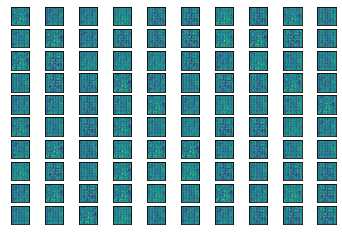

Epoch: 2
Discriminator Eigen Values
	 31.184433
	 34.881424
	 39.431927
	 40.919575
	 44.21972
	 50.70925
	 51.245667
	 66.63914
	 77.02246
	 155.66684
Generator Eigen Values
	 -95.875885
	 -58.82912
	 -36.819614
	 -32.534546
	 -30.187292
	 -27.290077
	 -25.180292
	 28.115301
	 38.35463
	 46.483616
Epoch: [ 2] [  50/ 200] D_loss: 0.94194961, G_loss: 1.43374860
Discriminator Eigen Values
	 -26.723627
	 -21.835085
	 23.008238
	 23.812086
	 27.902382
	 30.875244
	 33.756413
	 44.723366
	 60.07228
	 110.62935
Generator Eigen Values
	 -24.406162
	 -21.053596
	 -17.17579
	 -14.838303
	 11.978052
	 13.847308
	 14.470396
	 19.71355
	 20.21666
	 71.52104
Epoch: [ 2] [ 100/ 200] D_loss: 1.00670266, G_loss: 1.38204384
Discriminator Eigen Values
	 -46.704365
	 -37.112946
	 -31.991793
	 31.019718
	 32.438927
	 37.08178
	 41.661263
	 49.387806
	 60.621063
	 118.051994
Generator Eigen Values
	 -34.393147
	 -25.72791
	 -23.216488
	 -20.592737
	 -18.14682
	 -14.960382
	 15.587963
	 17.263973
	 26.95423

<Figure size 720x720 with 0 Axes>

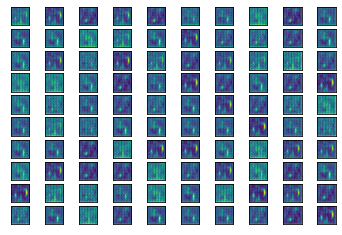

Epoch: 3
Discriminator Eigen Values
	 -23.90918
	 25.429945
	 29.064058
	 29.744244
	 35.652378
	 39.6382
	 43.247047
	 51.921623
	 96.55188
	 110.730354
Generator Eigen Values
	 -102.49221
	 -52.401787
	 -31.695702
	 -28.35754
	 -24.345758
	 -20.894096
	 -20.26918
	 -19.21095
	 -17.968447
	 41.72052
Epoch: [ 3] [  50/ 200] D_loss: 0.82060897, G_loss: 1.49131751
Discriminator Eigen Values
	 46.205547
	 47.81503
	 50.479527
	 52.27709
	 57.927418
	 63.354538
	 72.30677
	 88.29075
	 150.96446
	 195.09515
Generator Eigen Values
	 -130.1916
	 -82.703705
	 -50.459297
	 -42.45814
	 -35.36013
	 -30.809855
	 -28.994411
	 -27.497961
	 -25.877665
	 27.469498
Epoch: [ 3] [ 100/ 200] D_loss: 0.84342360, G_loss: 1.69312537
Discriminator Eigen Values
	 22.362741
	 26.50721
	 27.087767
	 31.636421
	 35.223095
	 42.91763
	 53.858887
	 77.409676
	 115.82136
	 187.61421
Generator Eigen Values
	 -75.005295
	 -51.660004
	 -36.143803
	 -30.252708
	 -28.18154
	 -26.484459
	 -24.94003
	 -23.468065
	 25.03942

<Figure size 720x720 with 0 Axes>

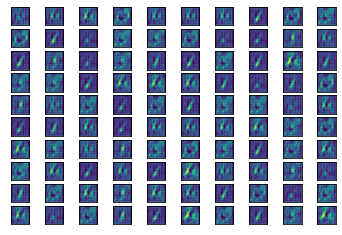

Epoch: 4
Discriminator Eigen Values
	 23.297697
	 24.05274
	 26.856201
	 29.262398
	 30.30216
	 39.53175
	 67.01334
	 76.740685
	 97.72485
	 146.38861
Generator Eigen Values
	 -95.63622
	 -36.50582
	 -34.473255
	 -28.377623
	 -25.50743
	 -22.233305
	 -20.46067
	 -18.765842
	 -17.812872
	 47.098038
Epoch: [ 4] [  50/ 200] D_loss: 0.78554499, G_loss: 1.59219098
Discriminator Eigen Values
	 27.611984
	 30.398846
	 33.76785
	 39.794147
	 48.156067
	 59.390404
	 73.990616
	 94.22792
	 113.33615
	 238.22574
Generator Eigen Values
	 -83.41875
	 -62.419273
	 -41.843826
	 -28.200193
	 -24.190102
	 24.961391
	 25.625376
	 26.933735
	 30.67282
	 34.73371
Epoch: [ 4] [ 100/ 200] D_loss: 0.81184357, G_loss: 1.75043011
Discriminator Eigen Values
	 18.112099
	 20.286964
	 21.309128
	 26.676548
	 34.978928
	 38.193146
	 43.95383
	 51.74953
	 90.42517
	 113.60826
Generator Eigen Values
	 -100.787575
	 -54.215633
	 -41.789677
	 -26.816935
	 -24.45855
	 -21.055653
	 -18.250704
	 -17.213697
	 -14.813646
	

<Figure size 720x720 with 0 Axes>

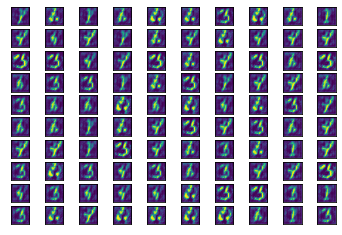

Epoch: 5
Discriminator Eigen Values
	 -27.47576
	 27.801453
	 29.92536
	 31.630634
	 36.401546
	 39.368263
	 50.774837
	 80.00625
	 114.55552
	 168.11162
Generator Eigen Values
	 -38.765892
	 -34.34717
	 -22.853334
	 -18.768604
	 -16.413586
	 -14.899986
	 -11.976719
	 -11.033052
	 13.138055
	 20.083479
Epoch: [ 5] [  50/ 200] D_loss: 0.79390907, G_loss: 1.62405729
Discriminator Eigen Values
	 -52.135044
	 32.90716
	 36.630447
	 37.32919
	 46.198128
	 47.186787
	 73.527336
	 92.89663
	 129.69373
	 206.47885
Generator Eigen Values
	 -56.654736
	 -47.647762
	 -41.4861
	 -34.68427
	 -30.769348
	 -30.454071
	 -29.701492
	 -29.328478
	 29.167929
	 76.38925
Epoch: [ 5] [ 100/ 200] D_loss: 0.90466845, G_loss: 1.79086554
Discriminator Eigen Values
	 24.940008
	 30.201887
	 32.72179
	 36.827934
	 41.797382
	 50.10154
	 63.72115
	 77.4679
	 79.405426
	 252.90439
Generator Eigen Values
	 -30.252872
	 -24.675503
	 -21.429976
	 -17.393522
	 18.661383
	 19.314734
	 20.050083
	 21.962582
	 32.50799
	 

<Figure size 720x720 with 0 Axes>

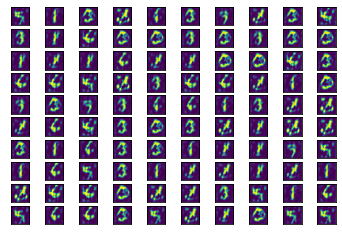

Epoch: 6
Discriminator Eigen Values
	 28.11706
	 33.901382
	 42.02605
	 46.048344
	 51.006866
	 62.79779
	 71.163376
	 90.09684
	 121.48396
	 396.41705
Generator Eigen Values
	 -59.864388
	 -33.615566
	 -27.29749
	 -24.244194
	 -22.492662
	 -18.469265
	 17.750397
	 18.767328
	 23.835148
	 59.026455
Epoch: [ 6] [  50/ 200] D_loss: 0.78976864, G_loss: 1.52014756
Discriminator Eigen Values
	 26.173058
	 26.700777
	 33.480427
	 34.983883
	 50.421265
	 52.513977
	 58.0422
	 83.59286
	 113.92785
	 331.33185
Generator Eigen Values
	 -67.34824
	 -27.271591
	 -23.444664
	 -21.844189
	 -17.890549
	 -16.711065
	 18.4327
	 19.324554
	 24.16767
	 34.2297
Epoch: [ 6] [ 100/ 200] D_loss: 0.80795658, G_loss: 1.57407641
Discriminator Eigen Values
	 24.768559
	 26.349955
	 31.739548
	 32.620533
	 40.250084
	 43.329006
	 56.38192
	 76.449104
	 92.459366
	 370.3149
Generator Eigen Values
	 -50.515827
	 -37.968887
	 -31.834908
	 -29.85137
	 -25.337769
	 -23.20851
	 -19.528849
	 19.371737
	 22.698418
	 31.4

<Figure size 720x720 with 0 Axes>

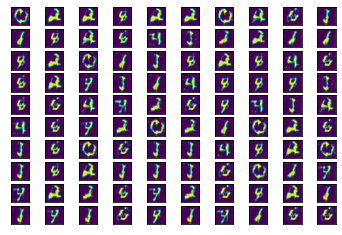

Epoch: 7
Discriminator Eigen Values
	 21.330942
	 22.58151
	 27.45741
	 30.528294
	 33.204723
	 46.50468
	 59.070717
	 75.42882
	 104.39723
	 244.2759
Generator Eigen Values
	 -51.286133
	 -34.667355
	 -19.911247
	 -19.544447
	 -18.663134
	 -15.968617
	 16.032503
	 17.642101
	 21.064854
	 31.571102
Epoch: [ 7] [  50/ 200] D_loss: 0.77328193, G_loss: 1.59861088
Discriminator Eigen Values
	 25.179337
	 26.92454
	 27.890593
	 33.97759
	 40.02493
	 46.293648
	 54.7599
	 65.570816
	 84.823204
	 327.9486
Generator Eigen Values
	 -62.869247
	 -48.816902
	 -37.96992
	 -28.947033
	 -19.551657
	 -18.01768
	 17.453823
	 20.473377
	 21.78283
	 29.606794
Epoch: [ 7] [ 100/ 200] D_loss: 0.79260671, G_loss: 1.59763432
Discriminator Eigen Values
	 32.086887
	 39.455418
	 47.972626
	 52.134514
	 53.94445
	 59.91783
	 82.78818
	 97.75449
	 117.8856
	 435.0424
Generator Eigen Values
	 -83.07324
	 -33.987183
	 -33.03868
	 28.85069
	 30.13474
	 31.656647
	 37.209496
	 39.07191
	 44.639565
	 58.64915
Epoch:

<Figure size 720x720 with 0 Axes>

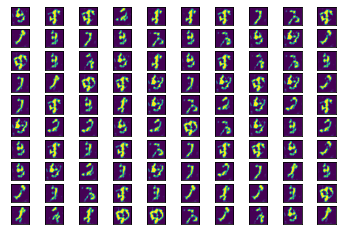

Epoch: 8
Discriminator Eigen Values
	 -66.94685
	 61.59532
	 68.1643
	 68.524185
	 71.90709
	 89.970375
	 111.812416
	 119.4962
	 126.68216
	 544.0132
Generator Eigen Values
	 -65.00229
	 -41.17598
	 -36.86315
	 -33.755043
	 -31.849333
	 -28.1966
	 28.012247
	 34.72447
	 39.254173
	 52.690647
Epoch: [ 8] [  50/ 200] D_loss: 1.02314126, G_loss: 2.03383088
Discriminator Eigen Values
	 33.10565
	 36.42295
	 39.86664
	 46.38962
	 54.407406
	 62.330097
	 75.71704
	 105.00152
	 129.5933
	 395.3475
Generator Eigen Values
	 -61.14264
	 -49.06214
	 -36.111942
	 -26.769474
	 23.520706
	 26.11316
	 31.526571
	 36.032402
	 37.36194
	 47.07693
Epoch: [ 8] [ 100/ 200] D_loss: 0.88057816, G_loss: 1.62894189
Discriminator Eigen Values
	 39.519867
	 41.95522
	 48.330563
	 57.301945
	 72.861626
	 79.23526
	 92.18926
	 111.00846
	 132.3277
	 459.55606
Generator Eigen Values
	 -117.8817
	 -58.70015
	 -51.240906
	 -46.897377
	 -34.76233
	 -33.032753
	 33.673233
	 35.815773
	 38.190983
	 44.383873
Epoch: [ 

<Figure size 720x720 with 0 Axes>

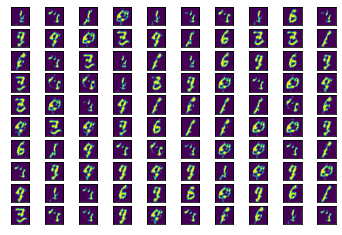

Epoch: 9
Discriminator Eigen Values
	 -56.803944
	 44.54941
	 47.85381
	 54.226627
	 60.269962
	 81.21435
	 96.11906
	 118.08813
	 154.36528
	 319.96823
Generator Eigen Values
	 -95.01858
	 -57.229347
	 -51.559814
	 -46.707623
	 -42.161312
	 -39.91524
	 -37.089455
	 -36.266155
	 -30.040394
	 52.60938
Epoch: [ 9] [  50/ 200] D_loss: 1.02113211, G_loss: 2.04997516
Discriminator Eigen Values
	 34.97713
	 37.489586
	 40.13189
	 41.87399
	 46.76238
	 64.78318
	 72.75522
	 117.36322
	 170.14465
	 355.20746
Generator Eigen Values
	 -82.507805
	 -59.611732
	 -44.710884
	 -40.70947
	 -39.467495
	 -35.571323
	 -32.18122
	 -26.259398
	 25.13311
	 38.734463
Epoch: [ 9] [ 100/ 200] D_loss: 0.84600317, G_loss: 1.66127384
Discriminator Eigen Values
	 31.146648
	 40.57775
	 51.299297
	 53.379402
	 57.41413
	 71.99024
	 93.357895
	 106.59808
	 131.38283
	 190.80649
Generator Eigen Values
	 -94.27281
	 -56.120884
	 -54.76146
	 -47.93066
	 -44.560585
	 -39.559856
	 -32.89406
	 31.793795
	 38.15019
	 50.8

<Figure size 720x720 with 0 Axes>

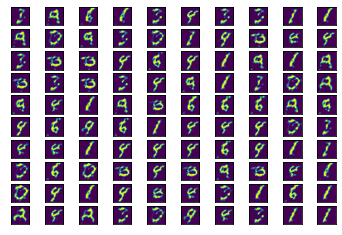

Epoch: 10
Discriminator Eigen Values
	 41.520966
	 48.421352
	 51.72318
	 56.652687
	 83.676025
	 90.032074
	 98.128685
	 127.01492
	 148.86478
	 459.1609
Generator Eigen Values
	 -71.25617
	 -47.02304
	 -40.402523
	 -37.89187
	 38.19798
	 40.400276
	 44.33297
	 47.987736
	 54.702385
	 90.57208
Epoch: [10] [  50/ 200] D_loss: 0.87969482, G_loss: 1.76598632
Discriminator Eigen Values
	 34.181496
	 40.4775
	 41.66462
	 46.855553
	 57.38482
	 60.64629
	 78.87332
	 92.64082
	 134.9767
	 293.6125
Generator Eigen Values
	 -90.05201
	 -57.684113
	 -48.203365
	 -46.191998
	 -39.86161
	 -37.308243
	 -33.477295
	 30.953543
	 44.669262
	 50.242413
Epoch: [10] [ 100/ 200] D_loss: 0.80430686, G_loss: 1.52943075
Discriminator Eigen Values
	 37.15959
	 42.95772
	 44.91658
	 46.35417
	 53.268784
	 66.044685
	 83.18678
	 97.20065
	 122.19733
	 223.95592
Generator Eigen Values
	 -53.87368
	 -44.52388
	 -36.373352
	 -33.30144
	 -30.731094
	 -30.527315
	 30.951899
	 35.124393
	 45.473125
	 50.750854
Epoch

<Figure size 720x720 with 0 Axes>

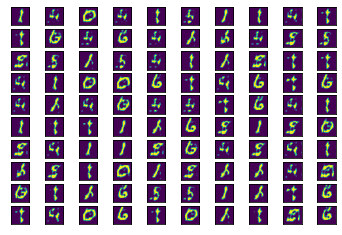

Epoch: 11
Discriminator Eigen Values
	 30.935905
	 35.68632
	 39.654465
	 42.173473
	 44.952785
	 54.87615
	 70.88766
	 85.17401
	 106.94689
	 322.53952
Generator Eigen Values
	 -74.23181
	 -56.503143
	 -43.75873
	 -40.013702
	 -35.499016
	 -32.661945
	 32.89269
	 36.18419
	 37.970566
	 58.22361
Epoch: [11] [  50/ 200] D_loss: 0.82359922, G_loss: 1.67455161
Discriminator Eigen Values
	 30.335829
	 32.5303
	 37.94245
	 41.340973
	 51.429977
	 63.227432
	 73.94174
	 80.85893
	 92.2631
	 181.26544
Generator Eigen Values
	 -64.147964
	 -57.65185
	 -49.635464
	 -44.294666
	 -40.718502
	 -35.238117
	 -32.806072
	 35.691658
	 45.790276
	 62.17543
Epoch: [11] [ 100/ 200] D_loss: 0.78043860, G_loss: 1.65140319
Discriminator Eigen Values
	 39.192028
	 45.013645
	 51.0113
	 52.88595
	 58.46884
	 63.684975
	 75.84288
	 103.326866
	 110.908646
	 369.8458
Generator Eigen Values
	 -142.58086
	 -95.12977
	 -74.322266
	 -66.31019
	 -59.792442
	 -50.285713
	 -45.11209
	 -41.798695
	 46.317543
	 60.69603

<Figure size 720x720 with 0 Axes>

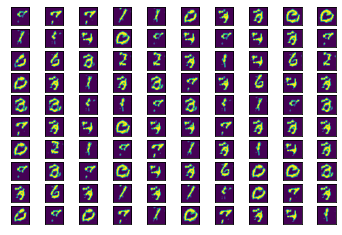

Epoch: 12
Discriminator Eigen Values
	 41.160866
	 46.56096
	 52.835724
	 64.39296
	 74.45754
	 86.65079
	 99.59073
	 116.65144
	 129.12769
	 546.5854
Generator Eigen Values
	 -118.882935
	 -76.20361
	 -70.80939
	 -52.537514
	 -46.806328
	 -45.82346
	 -40.04598
	 42.74718
	 47.882942
	 61.817726
Epoch: [12] [  50/ 200] D_loss: 0.79124767, G_loss: 1.63952935
Discriminator Eigen Values
	 33.48197
	 38.67894
	 40.871113
	 48.642307
	 57.421757
	 64.725136
	 78.70586
	 93.33939
	 112.3515
	 383.1415
Generator Eigen Values
	 -83.62124
	 -70.30648
	 -46.657364
	 -43.467354
	 -38.108482
	 42.53003
	 48.04027
	 50.500324
	 52.59298
	 64.21637
Epoch: [12] [ 100/ 200] D_loss: 0.83452368, G_loss: 1.66690648
Discriminator Eigen Values
	 51.00775
	 55.437115
	 70.90474
	 71.64353
	 82.423965
	 84.57841
	 93.99103
	 112.07973
	 135.83365
	 171.24866
Generator Eigen Values
	 -154.62987
	 -126.26559
	 -102.825874
	 -86.812065
	 -65.92603
	 -62.639153
	 -55.92817
	 -54.465527
	 -50.39433
	 49.845825
Ep

<Figure size 720x720 with 0 Axes>

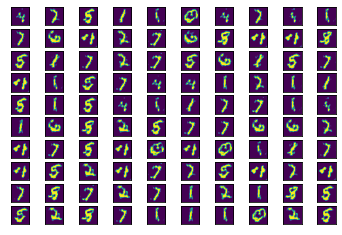

Epoch: 13
Discriminator Eigen Values
	 38.041523
	 39.463745
	 44.460575
	 50.598732
	 56.937714
	 71.53403
	 84.670815
	 106.94795
	 120.90388
	 171.54924
Generator Eigen Values
	 -142.37025
	 -91.45359
	 -76.024124
	 -66.32922
	 -59.457905
	 -50.61078
	 -43.609535
	 41.238007
	 49.83094
	 63.962196
Epoch: [13] [  50/ 200] D_loss: 0.81227076, G_loss: 1.60443938
Discriminator Eigen Values
	 38.48753
	 47.685184
	 53.572414
	 57.960464
	 67.88427
	 81.43631
	 84.82186
	 138.57271
	 144.83875
	 218.87407
Generator Eigen Values
	 -107.25129
	 -92.16771
	 -71.15255
	 -64.38781
	 -53.376293
	 -52.468758
	 49.74173
	 52.902252
	 67.275375
	 87.6494
Epoch: [13] [ 100/ 200] D_loss: 0.85185552, G_loss: 1.58252156
Discriminator Eigen Values
	 -46.285034
	 46.308826
	 48.272602
	 55.65043
	 67.024536
	 73.09783
	 77.302086
	 103.03541
	 119.76653
	 327.73874
Generator Eigen Values
	 -163.38814
	 -115.04966
	 -104.53792
	 -99.95094
	 -83.6249
	 -69.79522
	 -66.77353
	 -57.90613
	 -55.17997
	 78.00

<Figure size 720x720 with 0 Axes>

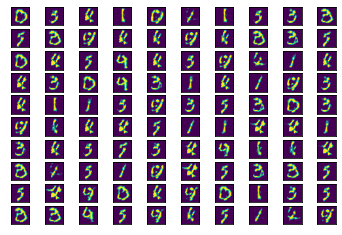

Epoch: 14
Discriminator Eigen Values
	 46.97872
	 50.433056
	 52.97289
	 64.152985
	 79.645226
	 97.993515
	 106.75168
	 133.78212
	 162.38202
	 408.5769
Generator Eigen Values
	 -251.83968
	 -158.36734
	 -125.31254
	 -82.403915
	 -78.32403
	 -74.17951
	 -71.065
	 -65.602005
	 75.52683
	 87.9574
Epoch: [14] [  50/ 200] D_loss: 0.82618582, G_loss: 1.74905300
Discriminator Eigen Values
	 40.706604
	 44.4332
	 50.30462
	 54.061924
	 58.06278
	 86.847984
	 89.02521
	 109.28366
	 131.27525
	 262.76575
Generator Eigen Values
	 -350.7373
	 -165.1096
	 -151.90158
	 -119.417114
	 -104.868454
	 -98.124435
	 -88.13984
	 -86.812
	 -83.74777
	 93.23493
Epoch: [14] [ 100/ 200] D_loss: 0.76968873, G_loss: 1.89835334
Discriminator Eigen Values
	 39.85769
	 44.954315
	 50.325775
	 55.588734
	 56.959904
	 69.864944
	 89.014175
	 119.0773
	 123.45562
	 280.83997
Generator Eigen Values
	 -237.20593
	 -172.92207
	 -125.01622
	 -110.49572
	 -83.60315
	 -69.91506
	 -67.526054
	 73.30909
	 85.52795
	 118.9463

<Figure size 720x720 with 0 Axes>

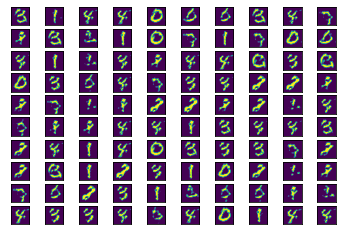

Epoch: 15
Discriminator Eigen Values
	 42.077957
	 45.54202
	 54.722
	 57.933712
	 61.683636
	 77.47343
	 92.433945
	 134.56204
	 139.03313
	 511.73175
Generator Eigen Values
	 -164.14569
	 -124.42673
	 -91.089165
	 -81.12361
	 -72.1626
	 -61.101295
	 68.87519
	 79.26171
	 87.55999
	 129.54268
Epoch: [15] [  50/ 200] D_loss: 0.88048315, G_loss: 1.71491218
Discriminator Eigen Values
	 45.984974
	 49.092052
	 56.400223
	 61.82302
	 68.63286
	 71.14384
	 78.71655
	 129.19449
	 135.19965
	 340.45944
Generator Eigen Values
	 -278.15173
	 -125.85547
	 -114.95962
	 -91.622055
	 -88.59323
	 -84.90696
	 -80.23988
	 -77.31487
	 -66.74424
	 84.5783
Epoch: [15] [ 100/ 200] D_loss: 0.83544904, G_loss: 1.70119047
Discriminator Eigen Values
	 54.977814
	 61.66668
	 67.554855
	 71.37717
	 85.69129
	 98.50544
	 99.51309
	 124.57734
	 149.67975
	 250.94614
Generator Eigen Values
	 -210.21791
	 -153.1958
	 -120.12307
	 -102.5477
	 -96.90009
	 -77.71116
	 -71.13773
	 -70.44556
	 83.30585
	 176.662
Epoch: 

<Figure size 720x720 with 0 Axes>

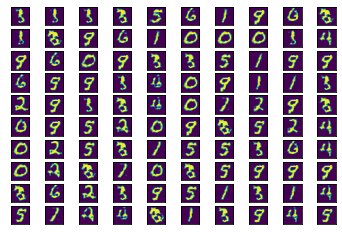

Epoch: 16
Discriminator Eigen Values
	 43.255432
	 47.680134
	 53.422832
	 56.72469
	 75.49185
	 79.06618
	 87.71727
	 117.37812
	 138.24539
	 265.4231
Generator Eigen Values
	 -234.81973
	 -187.90604
	 -166.70105
	 -141.17418
	 -129.82767
	 -118.69943
	 -110.46028
	 -94.07022
	 -88.27523
	 130.77454
Epoch: [16] [  50/ 200] D_loss: 0.81038284, G_loss: 1.80923319
Discriminator Eigen Values
	 41.391056
	 54.36425
	 57.602043
	 61.33732
	 67.81173
	 92.72173
	 110.19308
	 119.56367
	 158.77528
	 270.21255
Generator Eigen Values
	 -328.7072
	 -177.8875
	 -152.51167
	 -146.02347
	 -125.07555
	 -107.57882
	 -98.48968
	 -88.64519
	 -79.85243
	 80.19869
Epoch: [16] [ 100/ 200] D_loss: 0.79177260, G_loss: 1.61420083
Discriminator Eigen Values
	 31.439354
	 33.17634
	 37.492924
	 44.934536
	 51.87225
	 64.965065
	 71.83946
	 126.154526
	 136.48503
	 433.84012
Generator Eigen Values
	 -315.8767
	 -205.81328
	 -151.33322
	 -128.82042
	 -104.19052
	 -95.9675
	 -89.99901
	 -85.17038
	 -76.77172
	 -7

<Figure size 720x720 with 0 Axes>

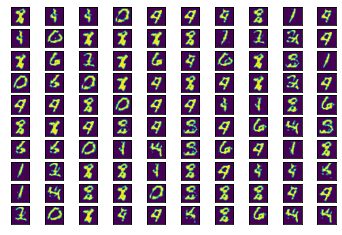

Epoch: 17
Discriminator Eigen Values
	 40.536335
	 43.05967
	 54.787037
	 56.22938
	 60.223076
	 75.502174
	 94.98685
	 128.07133
	 157.88313
	 248.11984
Generator Eigen Values
	 -461.20657
	 -258.43182
	 -187.50069
	 -172.71602
	 -151.97969
	 -130.71921
	 -128.8273
	 -111.82357
	 -108.480965
	 169.35924
Epoch: [17] [  50/ 200] D_loss: 0.74612319, G_loss: 1.97620320
Discriminator Eigen Values
	 -35.08391
	 36.356823
	 36.980587
	 42.138584
	 50.500187
	 54.946396
	 70.67896
	 81.105194
	 107.29324
	 330.892
Generator Eigen Values
	 -328.6466
	 -154.1593
	 -133.4492
	 -117.548386
	 -99.43567
	 -93.35413
	 -83.3564
	 -78.18911
	 -69.3418
	 67.79091
Epoch: [17] [ 100/ 200] D_loss: 0.89289284, G_loss: 2.04457045
Discriminator Eigen Values
	 48.793587
	 61.571945
	 66.25736
	 72.010025
	 80.95134
	 99.470055
	 102.38101
	 127.098305
	 193.44455
	 385.57635
Generator Eigen Values
	 -301.09338
	 -165.67021
	 -110.95463
	 -94.94528
	 92.32181
	 95.84541
	 98.12287
	 106.22235
	 117.45651
	 185

<Figure size 720x720 with 0 Axes>

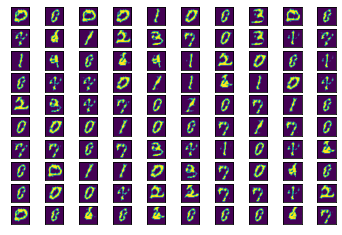

Epoch: 18
Discriminator Eigen Values
	 47.311985
	 57.10008
	 64.21911
	 73.9577
	 94.18035
	 98.94797
	 103.03193
	 140.60034
	 199.41745
	 454.6382
Generator Eigen Values
	 -375.3562
	 -281.9884
	 -223.10403
	 -206.16838
	 -196.90392
	 -162.33577
	 -146.78554
	 -142.24667
	 -131.62933
	 -126.39481
Epoch: [18] [  50/ 200] D_loss: 0.83773386, G_loss: 1.72989714
Discriminator Eigen Values
	 49.39399
	 54.276505
	 62.03377
	 69.75233
	 79.276276
	 109.56928
	 118.5116
	 129.58931
	 156.7649
	 333.76218
Generator Eigen Values
	 -323.14447
	 -174.09088
	 -142.903
	 -137.49594
	 -120.501366
	 -107.03394
	 -106.716156
	 -93.56416
	 90.417564
	 111.08327
Epoch: [18] [ 100/ 200] D_loss: 0.83864033, G_loss: 1.77037072
Discriminator Eigen Values
	 38.096493
	 39.53769
	 50.625313
	 56.528652
	 64.94014
	 77.97931
	 90.7697
	 106.212776
	 143.21367
	 305.9305
Generator Eigen Values
	 -286.76556
	 -184.40964
	 -109.34321
	 -100.25823
	 -83.860664
	 -77.99905
	 -76.315704
	 81.42938
	 92.97697
	 17

<Figure size 720x720 with 0 Axes>

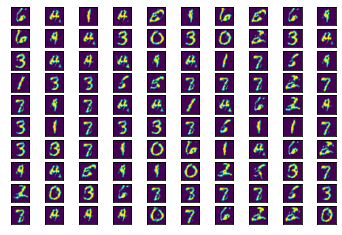

Epoch: 19
Discriminator Eigen Values
	 45.69324
	 54.59277
	 59.999687
	 64.01013
	 80.883484
	 93.79085
	 122.94436
	 147.56854
	 249.60696
	 307.34406
Generator Eigen Values
	 -529.15015
	 -254.9981
	 -171.47787
	 -147.17422
	 -136.90533
	 -128.69633
	 -124.378876
	 -120.891075
	 115.282135
	 230.30898
Epoch: [19] [  50/ 200] D_loss: 0.83180082, G_loss: 1.71284342
Discriminator Eigen Values
	 34.214813
	 38.623898
	 42.750717
	 55.034122
	 69.520096
	 80.57227
	 85.71107
	 94.97604
	 152.09071
	 225.87753
Generator Eigen Values
	 -540.25635
	 -306.26422
	 -215.58267
	 -210.71207
	 -177.49733
	 -156.9955
	 -145.54909
	 -134.39377
	 -127.43015
	 153.41862
Epoch: [19] [ 100/ 200] D_loss: 0.73317838, G_loss: 1.84291959
Discriminator Eigen Values
	 45.6233
	 48.3695
	 55.508507
	 72.082596
	 83.23346
	 95.14423
	 112.52752
	 128.5429
	 168.71686
	 287.00674
Generator Eigen Values
	 -372.57922
	 -260.62717
	 -170.83304
	 -165.86377
	 -145.48851
	 -137.46674
	 -132.30823
	 -122.744415
	 -11

<Figure size 720x720 with 0 Axes>

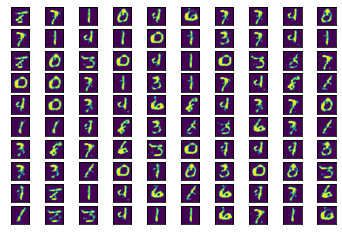

Epoch: 20
Discriminator Eigen Values
	 52.605988
	 61.664795
	 64.89494
	 70.539925
	 76.7711
	 106.19782
	 114.06222
	 159.86629
	 256.24686
	 403.45428
Generator Eigen Values
	 -373.5112
	 -275.82333
	 -197.59462
	 -167.14409
	 -145.63162
	 -140.03963
	 -126.47299
	 -119.23152
	 -108.21644
	 -100.55934
Epoch: [20] [  50/ 200] D_loss: 0.75707251, G_loss: 1.81731510
Discriminator Eigen Values
	 43.895306
	 46.107513
	 55.080444
	 60.720737
	 67.052795
	 90.90799
	 94.45516
	 117.60664
	 182.90819
	 333.93906
Generator Eigen Values
	 -400.47406
	 -272.22113
	 -214.24614
	 -170.85565
	 -161.57202
	 -146.36348
	 -124.800995
	 131.19032
	 155.97725
	 244.87198
Epoch: [20] [ 100/ 200] D_loss: 0.79846013, G_loss: 1.81935203
Discriminator Eigen Values
	 43.60764
	 47.950256
	 54.7769
	 57.800804
	 75.25003
	 81.70486
	 93.68765
	 96.76461
	 151.95436
	 317.26776
Generator Eigen Values
	 -556.273
	 -228.03557
	 -224.39445
	 -198.4449
	 -181.3223
	 -152.86093
	 -149.90627
	 -141.9015
	 -124.660

<Figure size 720x720 with 0 Axes>

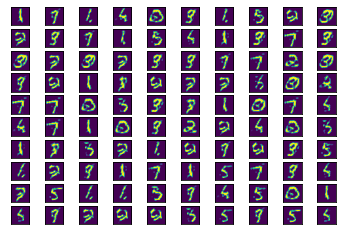

Epoch: 21
Discriminator Eigen Values
	 45.308296
	 49.51194
	 54.149506
	 61.111977
	 75.13492
	 102.84544
	 107.06645
	 114.139145
	 186.42885
	 319.37
Generator Eigen Values
	 -383.4844
	 -184.51321
	 -164.64958
	 -157.69113
	 -140.3699
	 -117.44004
	 -110.48529
	 -105.179924
	 106.78828
	 309.56876
Epoch: [21] [  50/ 200] D_loss: 0.76797652, G_loss: 1.83694625
Discriminator Eigen Values
	 51.91963
	 55.453785
	 59.298206
	 66.1576
	 70.626495
	 90.5768
	 131.75887
	 152.97652
	 215.86842
	 454.0403
Generator Eigen Values
	 -449.64713
	 -278.3231
	 -221.63504
	 -173.42712
	 -169.28256
	 -152.01616
	 -142.9326
	 -131.12819
	 148.58765
	 246.32788
Epoch: [21] [ 100/ 200] D_loss: 0.80105013, G_loss: 2.03390050
Discriminator Eigen Values
	 75.61949
	 77.45843
	 86.50351
	 94.62063
	 110.36473
	 123.952644
	 141.56018
	 183.41037
	 252.76355
	 574.3901
Generator Eigen Values
	 -342.71747
	 -239.98032
	 -185.96396
	 -166.3129
	 -150.94357
	 -144.1357
	 -132.88939
	 -125.59112
	 -110.575775

<Figure size 720x720 with 0 Axes>

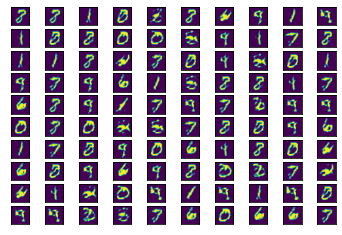

Epoch: 22
Discriminator Eigen Values
	 60.511566
	 61.81214
	 69.64677
	 86.267044
	 98.278305
	 101.51185
	 110.918465
	 163.94951
	 215.35962
	 462.5376
Generator Eigen Values
	 -356.16098
	 -191.75694
	 -158.57959
	 -138.74239
	 -132.47223
	 -116.34914
	 -110.00733
	 -103.98278
	 145.10384
	 213.99332
Epoch: [22] [  50/ 200] D_loss: 0.86138821, G_loss: 1.94177377
Discriminator Eigen Values
	 61.231224
	 65.976204
	 71.36709
	 81.763626
	 87.5603
	 114.11079
	 129.54045
	 225.02957
	 234.19409
	 549.428
Generator Eigen Values
	 -490.32214
	 -259.04147
	 -201.16838
	 -197.25174
	 -169.72871
	 -155.82173
	 -135.82626
	 -132.0442
	 -129.69604
	 168.77116
Epoch: [22] [ 100/ 200] D_loss: 0.84065390, G_loss: 2.06710100
Discriminator Eigen Values
	 52.247894
	 53.16346
	 53.993546
	 58.44983
	 94.36831
	 98.52887
	 120.22885
	 188.55547
	 193.18745
	 383.11725
Generator Eigen Values
	 -404.33582
	 -330.7927
	 -275.4559
	 -254.70512
	 -210.05528
	 -168.10861
	 -155.93994
	 -151.5165
	 158.24

<Figure size 720x720 with 0 Axes>

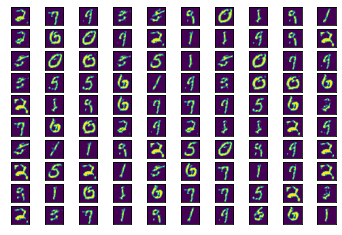

Epoch: 23
Discriminator Eigen Values
	 54.539394
	 57.538868
	 62.44083
	 73.92348
	 87.72569
	 102.67689
	 130.10478
	 136.49829
	 245.75978
	 531.19415
Generator Eigen Values
	 -417.89136
	 -317.6748
	 -196.11818
	 -158.06326
	 -144.51527
	 -132.35893
	 -120.87742
	 -113.30836
	 -111.06818
	 119.20047
Epoch: [23] [  50/ 200] D_loss: 0.76973289, G_loss: 1.78944039
Discriminator Eigen Values
	 64.25179
	 69.59467
	 79.21444
	 92.01379
	 105.65343
	 134.36082
	 160.89418
	 193.59814
	 248.90994
	 573.5531
Generator Eigen Values
	 -631.77655
	 -275.79398
	 -230.08034
	 -213.71169
	 -187.64388
	 -168.97876
	 -165.42682
	 -153.75725
	 -144.93605
	 -138.35385
Epoch: [23] [ 100/ 200] D_loss: 0.81850111, G_loss: 2.00762892
Discriminator Eigen Values
	 52.225147
	 59.167957
	 64.89128
	 75.89003
	 87.74406
	 93.88421
	 115.722305
	 149.10728
	 172.20024
	 456.59042
Generator Eigen Values
	 -400.32953
	 -277.39575
	 -240.96729
	 -190.39796
	 -175.24803
	 -149.74028
	 -144.44218
	 -132.11777
	 1

<Figure size 720x720 with 0 Axes>

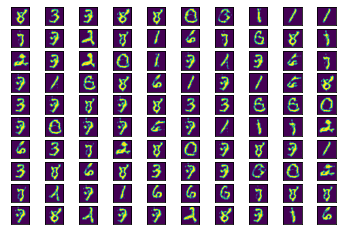

Epoch: 24
Discriminator Eigen Values
	 62.037354
	 65.927734
	 71.94796
	 85.80452
	 98.06849
	 106.38321
	 138.93074
	 161.45293
	 210.37302
	 363.72473
Generator Eigen Values
	 -552.7625
	 -260.05685
	 -208.81935
	 -188.35298
	 -171.99043
	 -167.19797
	 -149.87206
	 -144.05838
	 -134.22086
	 -122.58036
Epoch: [24] [  50/ 200] D_loss: 0.77029312, G_loss: 1.94036794
Discriminator Eigen Values
	 42.15684
	 46.2285
	 48.754803
	 57.291557
	 68.39624
	 83.941666
	 108.51708
	 122.8578
	 226.96274
	 324.06714
Generator Eigen Values
	 -410.19174
	 -231.37575
	 -220.7211
	 -199.4438
	 -189.62865
	 -169.93765
	 -167.58527
	 -150.0824
	 -141.54196
	 -136.76566
Epoch: [24] [ 100/ 200] D_loss: 0.76029634, G_loss: 1.89509785
Discriminator Eigen Values
	 64.04207
	 67.89679
	 75.2822
	 86.51802
	 110.256836
	 131.22708
	 172.43047
	 184.98978
	 232.12546
	 751.95233
Generator Eigen Values
	 -755.33246
	 -327.67776
	 -278.86707
	 -240.7498
	 -238.87535
	 -217.18541
	 -209.63963
	 -197.87067
	 -183.

<Figure size 720x720 with 0 Axes>

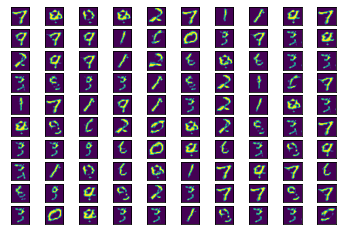

Epoch: 25
Discriminator Eigen Values
	 44.36
	 48.146736
	 53.627754
	 57.071697
	 80.66124
	 95.36212
	 114.33091
	 123.20025
	 186.3354
	 294.991
Generator Eigen Values
	 -418.62897
	 -246.6418
	 -192.51299
	 -165.91829
	 -150.53325
	 -145.82053
	 -137.39221
	 -115.56944
	 -110.08387
	 -103.873276
Epoch: [25] [  50/ 200] D_loss: 0.73212165, G_loss: 1.81898928
Discriminator Eigen Values
	 -87.629684
	 76.59612
	 78.993385
	 96.890594
	 99.39827
	 126.93289
	 137.71703
	 156.69414
	 233.9186
	 670.3639
Generator Eigen Values
	 -500.84155
	 -262.3623
	 -196.6495
	 -168.65077
	 -162.15247
	 -147.23575
	 -130.07114
	 -110.704575
	 -106.44216
	 137.37057
Epoch: [25] [ 100/ 200] D_loss: 1.45822024, G_loss: 2.78969097
Discriminator Eigen Values
	 46.428562
	 48.75145
	 64.891846
	 78.10151
	 83.16436
	 98.72736
	 105.15276
	 138.38148
	 202.6134
	 362.44595
Generator Eigen Values
	 -792.3329
	 -300.18063
	 -269.84818
	 -242.93938
	 -210.71182
	 -195.37285
	 -190.3031
	 -170.16484
	 -157.4393

<Figure size 720x720 with 0 Axes>

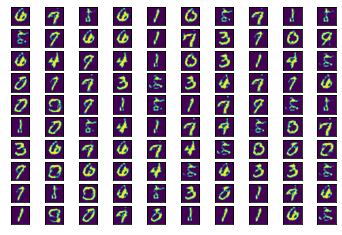

Epoch: 26
Discriminator Eigen Values
	 50.549664
	 58.105865
	 65.354576
	 71.6321
	 86.94157
	 93.60476
	 122.491234
	 142.45644
	 195.18404
	 416.18137
Generator Eigen Values
	 -371.36435
	 -186.76143
	 -162.39584
	 -137.75487
	 -129.91422
	 -123.70252
	 133.99313
	 142.23364
	 155.4392
	 219.72958
Epoch: [26] [  50/ 200] D_loss: 0.78461415, G_loss: 1.79372263
Discriminator Eigen Values
	 -34.78255
	 31.816744
	 36.788223
	 44.456455
	 46.236324
	 53.283333
	 72.72637
	 98.79738
	 105.031555
	 299.60806
Generator Eigen Values
	 -545.0076
	 -221.64319
	 -196.09804
	 -176.51874
	 -166.9148
	 -160.97987
	 -145.09209
	 -140.51979
	 -132.19385
	 -129.37822
Epoch: [26] [ 100/ 200] D_loss: 0.82105237, G_loss: 2.22822738
Discriminator Eigen Values
	 56.94796
	 61.26569
	 67.483635
	 75.10881
	 90.15142
	 95.254135
	 102.10075
	 147.69197
	 268.43176
	 422.40973
Generator Eigen Values
	 -469.97336
	 -263.68723
	 -215.78812
	 -205.03644
	 -188.05319
	 -175.48778
	 -166.99013
	 150.27995
	 239.

<Figure size 720x720 with 0 Axes>

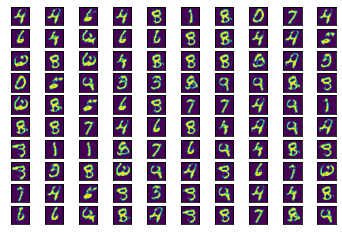

Epoch: 27
Discriminator Eigen Values
	 50.91804
	 57.556404
	 62.61937
	 68.107864
	 90.682526
	 111.36711
	 132.0892
	 159.68858
	 215.38806
	 273.23166
Generator Eigen Values
	 -620.79407
	 -363.21518
	 -288.13986
	 -237.59904
	 -231.26152
	 -202.07944
	 -188.6217
	 -176.72014
	 -163.64821
	 165.4047
Epoch: [27] [  50/ 200] D_loss: 0.76050323, G_loss: 1.93969524
Discriminator Eigen Values
	 43.470314
	 46.79124
	 52.053436
	 60.78336
	 67.72771
	 81.27418
	 85.46402
	 113.01852
	 175.02074
	 358.92908
Generator Eigen Values
	 -986.6007
	 -382.02188
	 -285.0723
	 -237.49063
	 -218.92172
	 -210.5769
	 -187.73166
	 -176.678
	 -175.94322
	 -173.2693
Epoch: [27] [ 100/ 200] D_loss: 0.75288010, G_loss: 1.88836324
Discriminator Eigen Values
	 49.05581
	 52.478245
	 59.11995
	 68.2921
	 76.827515
	 88.93089
	 108.37702
	 130.26094
	 208.41696
	 322.95337
Generator Eigen Values
	 -698.65216
	 -300.32
	 -250.89455
	 -239.91814
	 -226.08575
	 -205.31187
	 -191.46217
	 -179.45186
	 -171.90746
	 

<Figure size 720x720 with 0 Axes>

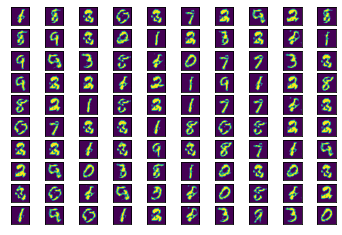

Epoch: 28
Discriminator Eigen Values
	 51.88865
	 63.199005
	 73.86633
	 85.26451
	 91.84616
	 105.60355
	 138.46442
	 145.40411
	 192.93832
	 308.30725
Generator Eigen Values
	 -749.9552
	 -524.4344
	 -315.10123
	 -255.60342
	 -247.54834
	 -219.69196
	 -209.43768
	 -186.05591
	 201.8782
	 313.68198
Epoch: [28] [  50/ 200] D_loss: 0.73520315, G_loss: 1.99756050
Discriminator Eigen Values
	 56.088615
	 70.94929
	 71.42894
	 93.2252
	 110.905266
	 114.9995
	 131.3797
	 175.39171
	 219.00125
	 464.02643
Generator Eigen Values
	 -735.00977
	 -511.41342
	 -381.1125
	 -303.80313
	 -261.85648
	 -247.71925
	 -237.4778
	 -219.65942
	 -205.87628
	 -198.60722
Epoch: [28] [ 100/ 200] D_loss: 0.74291337, G_loss: 1.94833100
Discriminator Eigen Values
	 48.088127
	 50.84525
	 60.77795
	 63.513363
	 71.67335
	 82.96157
	 100.36849
	 138.03508
	 216.33102
	 378.09457
Generator Eigen Values
	 -573.4485
	 -270.25616
	 -206.96353
	 -188.44154
	 -185.83377
	 -184.41957
	 -163.85327
	 -159.14282
	 -147.2367

<Figure size 720x720 with 0 Axes>

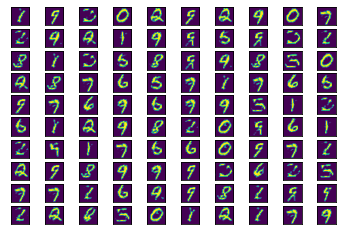

Epoch: 29
Discriminator Eigen Values
	 85.468636
	 94.42787
	 111.45843
	 118.213066
	 133.24773
	 146.90993
	 175.98009
	 218.96335
	 295.59213
	 721.9628
Generator Eigen Values
	 -694.2046
	 -434.98404
	 -338.9897
	 -319.7091
	 -284.22003
	 -259.2504
	 -246.98265
	 -227.66808
	 -222.06284
	 224.53903
Epoch: [29] [  50/ 200] D_loss: 0.86011851, G_loss: 2.23484349
Discriminator Eigen Values
	 66.28636
	 72.18454
	 77.38068
	 80.981735
	 89.3884
	 97.92396
	 114.06955
	 163.37495
	 189.24777
	 582.74756
Generator Eigen Values
	 -374.00797
	 -263.87573
	 -219.81778
	 -210.05298
	 -200.70735
	 -188.19774
	 -176.32106
	 156.97066
	 194.31349
	 208.31894
Epoch: [29] [ 100/ 200] D_loss: 0.76887858, G_loss: 1.80936289
Discriminator Eigen Values
	 60.52876
	 63.95278
	 71.822235
	 77.866875
	 87.23967
	 93.39124
	 105.33171
	 135.63332
	 237.49548
	 807.9428
Generator Eigen Values
	 -538.8504
	 -382.56708
	 -318.16895
	 -270.05795
	 -232.85187
	 -209.89632
	 -203.81914
	 -190.63078
	 -177.8246

<Figure size 720x720 with 0 Axes>

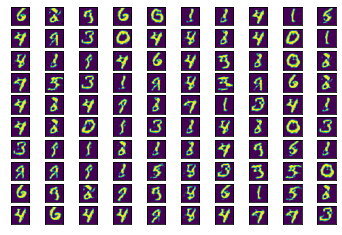

Epoch: 30
Discriminator Eigen Values
	 57.0575
	 61.843636
	 70.18638
	 80.20124
	 87.97718
	 102.11008
	 134.69914
	 152.48268
	 157.88835
	 536.54553
Generator Eigen Values
	 -700.86145
	 -365.0131
	 -341.73746
	 -282.1445
	 -256.97278
	 -229.61127
	 254.28038
	 282.96796
	 419.86563
	 740.33765
Epoch: [30] [  50/ 200] D_loss: 0.76517957, G_loss: 1.98354757
Discriminator Eigen Values
	 64.25354
	 65.93855
	 72.65164
	 83.82451
	 89.35445
	 104.407326
	 110.912865
	 162.30412
	 459.4582
	 617.721
Generator Eigen Values
	 -905.7828
	 -506.16013
	 -321.274
	 -281.8973
	 -274.89993
	 -241.37448
	 -223.18901
	 -210.4922
	 248.64743
	 268.13257
Epoch: [30] [ 100/ 200] D_loss: 0.81864583, G_loss: 1.84161055
Discriminator Eigen Values
	 64.819275
	 70.01317
	 83.291466
	 93.63672
	 100.26375
	 107.48686
	 118.06448
	 197.26904
	 375.18976
	 556.6307
Generator Eigen Values
	 -828.6957
	 -466.78427
	 -385.326
	 -346.277
	 -333.04688
	 -299.8199
	 -286.02917
	 -255.65297
	 -249.65959
	 -237.591

<Figure size 720x720 with 0 Axes>

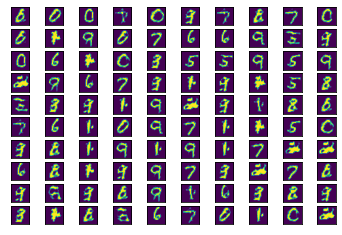

Epoch: 31
Discriminator Eigen Values
	 45.514797
	 49.069214
	 57.452244
	 67.22939
	 74.64176
	 83.93045
	 97.954056
	 109.85941
	 214.27322
	 537.39764
Generator Eigen Values
	 -785.67444
	 -428.91663
	 -352.27057
	 -301.75537
	 -277.4221
	 -262.71313
	 245.27077
	 252.61652
	 288.87527
	 336.87085
Epoch: [31] [  50/ 200] D_loss: 0.79809916, G_loss: 2.00323701
Discriminator Eigen Values
	 53.234272
	 58.812984
	 64.03147
	 77.18486
	 86.14512
	 98.247925
	 113.21483
	 158.49579
	 247.69269
	 468.67578
Generator Eigen Values
	 -561.1208
	 -359.576
	 -322.55978
	 -296.7346
	 -262.995
	 -255.08249
	 -236.29488
	 265.60553
	 321.33713
	 410.6593
Epoch: [31] [ 100/ 200] D_loss: 0.78138435, G_loss: 1.95383751
Discriminator Eigen Values
	 47.198116
	 49.984257
	 53.685432
	 58.42514
	 67.449974
	 80.37559
	 87.83071
	 125.569916
	 334.0366
	 544.8394
Generator Eigen Values
	 -981.90906
	 -410.83795
	 -366.21292
	 -345.50128
	 -318.6251
	 -293.217
	 -262.06943
	 -248.08806
	 -236.97737
	 268

<Figure size 720x720 with 0 Axes>

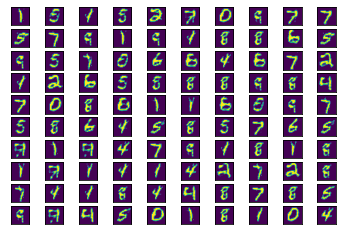

Epoch: 32
Discriminator Eigen Values
	 58.634556
	 65.19058
	 77.416176
	 90.75074
	 93.34784
	 115.09495
	 139.8277
	 186.92442
	 291.7467
	 793.7964
Generator Eigen Values
	 -1074.9553
	 -542.77625
	 -452.0475
	 -424.43854
	 -358.5433
	 -356.51654
	 -315.5011
	 -278.5017
	 -261.478
	 350.51202
Epoch: [32] [  50/ 200] D_loss: 0.80665231, G_loss: 2.09114909
Discriminator Eigen Values
	 60.04277
	 63.01875
	 66.80122
	 78.97527
	 89.00018
	 105.64251
	 127.69267
	 152.0592
	 312.03122
	 532.21936
Generator Eigen Values
	 -1807.1538
	 -848.5674
	 -564.24146
	 -529.2604
	 -418.07224
	 -400.0002
	 -362.1475
	 -348.00504
	 -320.9304
	 -303.9063
Epoch: [32] [ 100/ 200] D_loss: 0.74399906, G_loss: 1.89810574
Discriminator Eigen Values
	 54.79138
	 58.063152
	 62.52659
	 71.03129
	 92.83841
	 98.39686
	 114.13062
	 142.2116
	 242.56955
	 423.4035
Generator Eigen Values
	 -998.0746
	 -574.6123
	 -459.21753
	 -367.92862
	 -316.45703
	 -298.56863
	 -297.17725
	 -278.26465
	 -263.66373
	 275.66397

<Figure size 720x720 with 0 Axes>

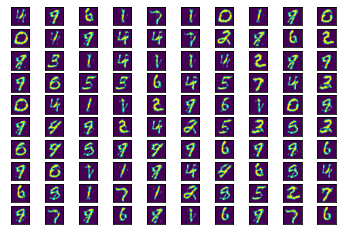

Epoch: 33
Discriminator Eigen Values
	 55.94456
	 58.31616
	 65.31067
	 75.76657
	 93.984024
	 100.37275
	 114.87972
	 148.67822
	 359.15976
	 425.06445
Generator Eigen Values
	 -628.3186
	 -503.26062
	 -419.2998
	 -399.94205
	 -364.48074
	 -295.07654
	 -267.34927
	 -250.59589
	 308.8231
	 496.7272
Epoch: [33] [  50/ 200] D_loss: 0.83289754, G_loss: 2.14457417
Discriminator Eigen Values
	 72.806496
	 78.4903
	 87.71509
	 95.431305
	 108.36895
	 120.73162
	 137.10146
	 184.305
	 433.65387
	 661.4321
Generator Eigen Values
	 -1146.6724
	 -757.588
	 -518.37976
	 -429.06937
	 -353.04752
	 -311.06845
	 -293.48077
	 -276.20926
	 -250.88042
	 -240.97449
Epoch: [33] [ 100/ 200] D_loss: 0.78649449, G_loss: 1.92676198
Discriminator Eigen Values
	 85.25359
	 93.69738
	 97.64537
	 108.52328
	 117.39335
	 140.61313
	 151.60638
	 237.23825
	 485.03403
	 782.3678
Generator Eigen Values
	 -1171.6224
	 -625.7584
	 -445.34155
	 -414.34784
	 -340.64194
	 -304.4831
	 -279.5406
	 -256.73648
	 -247.09001
	 

<Figure size 720x720 with 0 Axes>

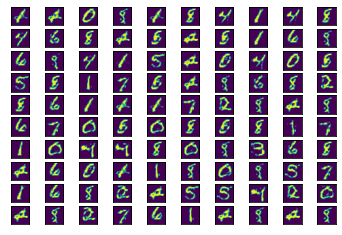

Epoch: 34
Discriminator Eigen Values
	 61.13132
	 63.54476
	 72.00879
	 88.04221
	 92.37767
	 111.16063
	 123.62507
	 171.73593
	 383.20364
	 430.60123
Generator Eigen Values
	 -603.7178
	 -500.621
	 -425.36777
	 -354.83475
	 -296.11438
	 -280.16733
	 282.2588
	 341.21472
	 360.71603
	 377.28113
Epoch: [34] [  50/ 200] D_loss: 0.71802723, G_loss: 2.07452106
Discriminator Eigen Values
	 67.5246
	 72.08049
	 75.34227
	 82.000565
	 87.10918
	 107.55528
	 138.1605
	 157.37126
	 218.66211
	 597.55096
Generator Eigen Values
	 -810.2111
	 -571.2904
	 -409.18945
	 -321.8816
	 -307.15793
	 -283.42096
	 -276.1101
	 -257.7482
	 290.5901
	 490.8049
Epoch: [34] [ 100/ 200] D_loss: 0.77513969, G_loss: 2.24755216
Discriminator Eigen Values
	 60.51945
	 64.12931
	 75.812355
	 85.739624
	 94.93845
	 107.3553
	 122.45568
	 201.48544
	 314.36758
	 696.30414
Generator Eigen Values
	 -924.5925
	 -507.79364
	 -447.16223
	 -393.88596
	 -357.3243
	 -328.0889
	 -311.62808
	 -274.33112
	 -268.94873
	 402.45145


<Figure size 720x720 with 0 Axes>

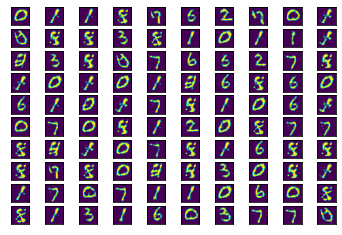

Epoch: 35
Discriminator Eigen Values
	 58.273697
	 66.161575
	 69.223045
	 75.320984
	 80.42156
	 103.04015
	 114.98411
	 157.59616
	 380.83636
	 879.0309
Generator Eigen Values
	 -1165.5624
	 -720.7345
	 -506.8894
	 -489.66287
	 -430.04037
	 -351.44556
	 -323.40683
	 -320.2203
	 363.14532
	 543.5656
Epoch: [35] [  50/ 200] D_loss: 0.77823877, G_loss: 1.98692715
Discriminator Eigen Values
	 54.490772
	 58.43402
	 60.668747
	 74.8448
	 86.37818
	 90.63297
	 103.53322
	 111.799576
	 210.74748
	 766.42303
Generator Eigen Values
	 -1226.9286
	 -626.1039
	 -537.25476
	 -509.37466
	 -393.8944
	 -349.01013
	 -329.77567
	 -316.1879
	 -291.92783
	 -288.9034
Epoch: [35] [ 100/ 200] D_loss: 0.83036166, G_loss: 2.47217321
Discriminator Eigen Values
	 48.41707
	 55.080334
	 65.69135
	 70.5442
	 85.45395
	 102.40536
	 132.61304
	 184.72263
	 330.48572
	 384.73532
Generator Eigen Values
	 -1384.916
	 -501.9515
	 -451.75378
	 -390.36597
	 -368.12158
	 -346.47482
	 -320.29022
	 -304.56317
	 -291.18982


<Figure size 720x720 with 0 Axes>

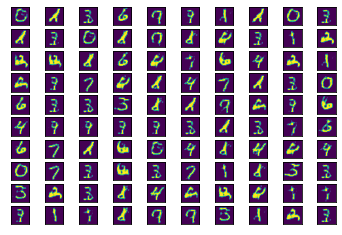

Epoch: 36
Discriminator Eigen Values
	 51.41753
	 64.869865
	 74.85948
	 85.74633
	 97.53173
	 106.084
	 166.85849
	 178.4534
	 398.7176
	 595.2849
Generator Eigen Values
	 -1082.8514
	 -875.0278
	 -589.5161
	 -473.96906
	 -451.06683
	 -399.4247
	 -359.7023
	 -329.21323
	 339.75046
	 436.94003
Epoch: [36] [  50/ 200] D_loss: 0.75152189, G_loss: 2.11452484
Discriminator Eigen Values
	 58.054943
	 58.512825
	 69.41946
	 75.01837
	 86.22536
	 97.56732
	 113.36885
	 179.1044
	 364.76306
	 424.4302
Generator Eigen Values
	 -749.7596
	 -534.0926
	 -434.83206
	 -396.09454
	 -376.17136
	 -334.81488
	 -301.1598
	 -283.50836
	 -271.33868
	 426.97455
Epoch: [36] [ 100/ 200] D_loss: 0.77457833, G_loss: 1.99462509
Discriminator Eigen Values
	 64.12212
	 66.05524
	 73.00127
	 77.885086
	 100.24117
	 103.20245
	 131.68181
	 166.93295
	 269.3878
	 1047.9629
Generator Eigen Values
	 -676.30365
	 -526.2774
	 -446.01608
	 -388.9497
	 -370.17947
	 -348.4655
	 -325.5571
	 -299.30762
	 307.30545
	 497.70447

<Figure size 720x720 with 0 Axes>

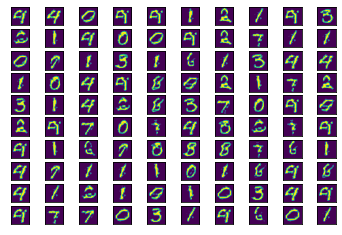

Epoch: 37
Discriminator Eigen Values
	 -80.70105
	 59.816536
	 63.18006
	 85.702156
	 88.5106
	 102.87565
	 124.567215
	 212.3676
	 270.87207
	 454.73987
Generator Eigen Values
	 -963.966
	 -658.70325
	 -482.87183
	 -450.1857
	 -439.8676
	 -390.85574
	 -366.8446
	 -337.6879
	 -320.86823
	 -301.8001
Epoch: [37] [  50/ 200] D_loss: 0.75211358, G_loss: 1.96376026
Discriminator Eigen Values
	 52.34147
	 53.632008
	 60.06813
	 67.03123
	 70.46396
	 80.54888
	 111.80492
	 133.353
	 292.66507
	 676.9955
Generator Eigen Values
	 -1246.9895
	 -678.33325
	 -559.7178
	 -485.9262
	 -452.4838
	 -434.39026
	 -390.65063
	 -358.97046
	 -342.94052
	 -324.5207
Epoch: [37] [ 100/ 200] D_loss: 0.75474459, G_loss: 2.29824185
Discriminator Eigen Values
	 46.906624
	 54.90349
	 62.140347
	 68.018196
	 73.65076
	 83.09144
	 92.46448
	 153.58154
	 253.09229
	 378.6053
Generator Eigen Values
	 -1062.3496
	 -617.93115
	 -560.5491
	 -512.3644
	 -443.5382
	 -425.06146
	 -357.14188
	 -314.17007
	 -305.4845
	 309.31

<Figure size 720x720 with 0 Axes>

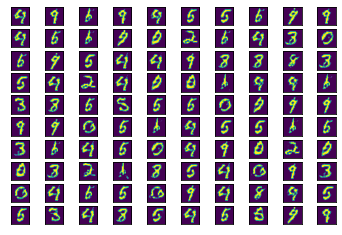

Epoch: 38
Discriminator Eigen Values
	 47.096817
	 50.18907
	 57.128887
	 65.21154
	 85.44763
	 93.11265
	 111.64368
	 157.98782
	 285.13773
	 387.59222
Generator Eigen Values
	 -997.5155
	 -634.1636
	 -547.6481
	 -486.95255
	 -420.0854
	 -341.16235
	 -340.27908
	 -310.41937
	 -289.03625
	 378.04794
Epoch: [38] [  50/ 200] D_loss: 0.71782416, G_loss: 1.93886924
Discriminator Eigen Values
	 61.727097
	 65.604805
	 70.292595
	 77.41946
	 89.33509
	 101.15688
	 119.00232
	 190.41914
	 220.46791
	 538.55536
Generator Eigen Values
	 -1663.6449
	 -593.3852
	 -556.7408
	 -520.1194
	 -491.1943
	 -470.56113
	 -421.96207
	 -401.3062
	 -378.3836
	 -362.57825
Epoch: [38] [ 100/ 200] D_loss: 0.83702970, G_loss: 2.37461519
Discriminator Eigen Values
	 48.8045
	 53.509705
	 56.225594
	 65.72759
	 79.467094
	 84.334076
	 89.37676
	 120.19792
	 294.24316
	 417.02798
Generator Eigen Values
	 -983.1026
	 -672.3762
	 -519.08636
	 -418.0024
	 -415.40366
	 -351.79672
	 -327.1559
	 -324.19977
	 -293.74646
	 

<Figure size 720x720 with 0 Axes>

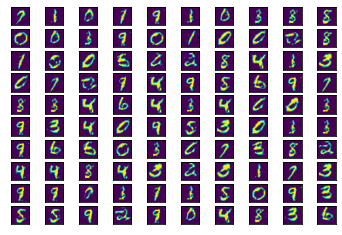

Epoch: 39
Discriminator Eigen Values
	 69.92116
	 74.15615
	 82.355385
	 92.68721
	 103.802345
	 131.08026
	 138.8408
	 219.5308
	 255.34868
	 775.30316
Generator Eigen Values
	 -1224.7288
	 -841.74603
	 -565.447
	 -474.06744
	 -387.95822
	 -355.67285
	 -344.73502
	 -334.27298
	 -316.08374
	 351.19455
Epoch: [39] [  50/ 200] D_loss: 0.76628709, G_loss: 1.94872975
Discriminator Eigen Values
	 58.002323
	 66.7811
	 70.90679
	 77.18673
	 88.30283
	 99.788826
	 111.38393
	 151.60666
	 370.70312
	 462.90753
Generator Eigen Values
	 -892.66547
	 -585.01245
	 -505.97708
	 -472.51294
	 -406.36478
	 -391.58575
	 -368.9578
	 362.05423
	 434.9714
	 527.4086
Epoch: [39] [ 100/ 200] D_loss: 0.73751998, G_loss: 1.90604329
Discriminator Eigen Values
	 54.642242
	 56.727222
	 68.37874
	 86.64187
	 88.09948
	 113.28294
	 136.3451
	 161.43964
	 331.63507
	 526.04926
Generator Eigen Values
	 -1305.8022
	 -988.9116
	 -794.92053
	 -615.58276
	 -520.4891
	 -447.35315
	 -414.69824
	 -390.64902
	 -367.97543
	

<Figure size 720x720 with 0 Axes>

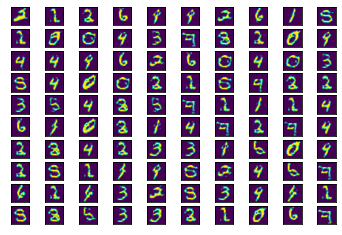

Epoch: 40
Discriminator Eigen Values
	 48.964443
	 51.049347
	 62.79273
	 65.42826
	 82.73666
	 106.135605
	 120.45477
	 145.02036
	 360.28976
	 506.8485
Generator Eigen Values
	 -1000.4858
	 -617.46716
	 -532.25525
	 -490.02194
	 -424.37152
	 -334.76077
	 -319.5252
	 346.89813
	 390.57568
	 564.7065
Epoch: [40] [  50/ 200] D_loss: 0.72631872, G_loss: 1.96459460
Discriminator Eigen Values
	 45.111675
	 46.127254
	 51.496704
	 68.14346
	 79.24924
	 87.38175
	 122.46404
	 147.12854
	 300.89706
	 397.67178
Generator Eigen Values
	 -1786.6263
	 -704.837
	 -625.75806
	 -499.36716
	 -476.99173
	 -397.9781
	 -386.94223
	 -375.39722
	 -356.1331
	 369.65186
Epoch: [40] [ 100/ 200] D_loss: 0.74986917, G_loss: 2.26383805
Discriminator Eigen Values
	 54.55529
	 66.48619
	 72.16594
	 73.73436
	 82.05528
	 108.28578
	 116.55037
	 128.45102
	 399.9451
	 512.4113
Generator Eigen Values
	 -1661.4196
	 -914.3934
	 -773.9666
	 -697.98865
	 -622.2084
	 -515.2241
	 -476.9771
	 -427.6005
	 -406.02277
	 -384

<Figure size 720x720 with 0 Axes>

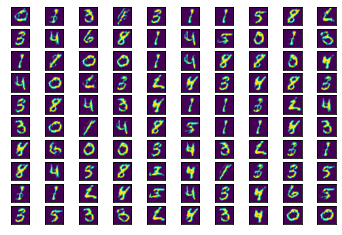

Training finished!


In [16]:
params = {'beta1': 0.5, 'beta2': 0.999,'lr_g':0.0002,'lr_d':0.0002,'max_epochs':40}
params['z_dim'] = 1
params['base_size'] = 64

gan = GAN(params)
gan.train()

# Loss History for GAN optimization

* The <font color='lightblue'>discriminator</font> loss will achieve a low value when it can reliably 
separate the two classes.

* The <font color='red'>generator</font> loss will achieve a low value when it can successfully fool the discriminator

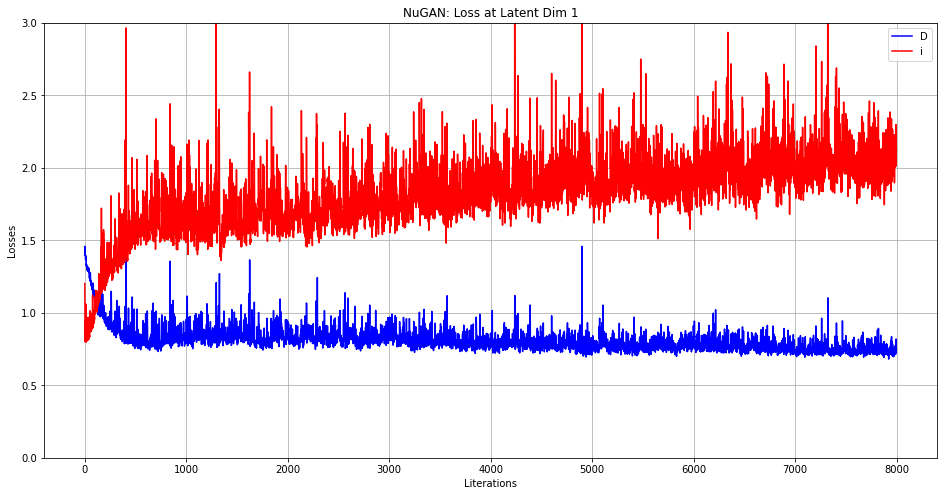

In [17]:
plt.figure(figsize=(16,8))
s=plt.plot(gan.train_hist['D_loss'],c='b')
s=plt.plot(gan.train_hist['G_loss'],c='r')
s = plt.ylim((0,3))
s = plt.grid()
s=plt.legend(('Discriminator loss'))
s=plt.title("NuGAN: Loss at Latent Dim " + str(gan.z_dim))
s=plt.ylabel("Losses")
s=plt.xlabel("Literations")

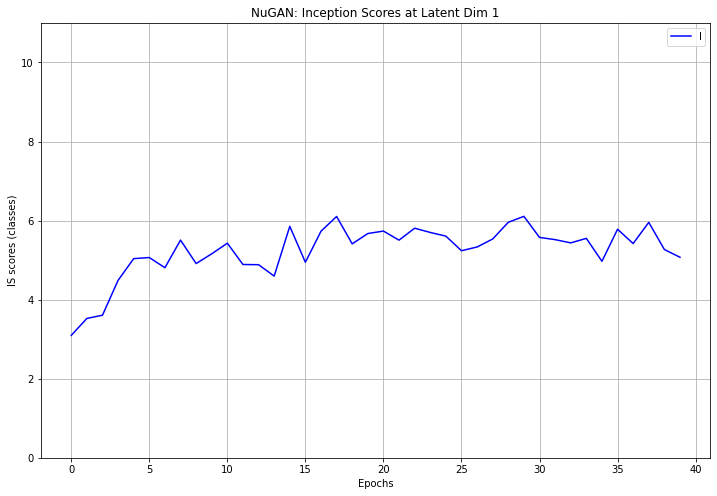

In [18]:
plt.figure(figsize=(12,8))
s=plt.plot(gan.train_hist['IS_score'],c='b')
s = plt.ylim((0,11))
s = plt.grid()
s=plt.legend(('Inception Score'))
s=plt.title("NuGAN: Inception Scores at Latent Dim " + str(gan.z_dim))
s=plt.ylabel("IS scores (classes)")
s=plt.xlabel("Epochs")

In [19]:
eps=1E-16
# conditional probabilities for high quality images
p_yx = np.asarray([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
print("p_yx:\n", p_yx)
# calculate p(y)
p_y = np.expand_dims(p_yx.mean(axis=0), 0)
print("p_y:\n", p_y)
# kl divergence for each image
kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
print(kl_d.shape)
print("kl_d:\n", kl_d)
# sum over classes
sum_kl_d = kl_d.sum(axis=1)
print(sum_kl_d.shape)
print("sum_kl_d:\n", sum_kl_d)
# average over images
avg_kl_d = np.mean(sum_kl_d)
print(avg_kl_d.shape)
print(avg_kl_d)
# undo the logs
is_score = np.exp(avg_kl_d)
print(is_score)

p_yx:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
p_y:
 [[0.33333333 0.33333333 0.33333333]]
(3, 3)
kl_d:
 [[ 1.09861229 -0.         -0.        ]
 [-0.          1.09861229 -0.        ]
 [-0.         -0.          1.09861229]]
(3,)
sum_kl_d:
 [1.09861229 1.09861229 1.09861229]
()
1.0986122886681093
2.999999999999999
